<a href="https://colab.research.google.com/github/Akbar453/Digit-Recognizer/blob/main/Digit_Recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"syedmohammadakbar","key":"9ee098c45e6c553d292d621adc38d61c"}'}

In [20]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [21]:
!pip install kaggle


In [22]:
!kaggle competitions download -c digit-recognizer


 72% 11.0M/15.3M [00:00<00:00, 114MB/s]
100% 15.3M/15.3M [00:00<00:00, 134MB/s]


In [23]:
!unzip digit-recognizer.zip


Archive:  digit-recognizer.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
%matplotlib inline
# plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'

In [25]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    return A

def softmax(z):
    expZ = np.exp(z)
    return expZ/(np.sum(expZ, 0))

def relu(Z):
    A = np.maximum(0,Z)
    return A

def tanh(x):
    return np.tanh(x)

def derivative_relu(Z):
    return np.array(Z > 0, dtype = 'float')

def derivative_tanh(x):
    return (1 - x ** 2)

**intilization of parameter with He**
_If you have heard of "Xavier initialization", this is similar except Xavier initialization uses a scaling factor for the weights  
W
[
l
]
  of sqrt(1./layers_dims[l-1]) where He initialization would use sqrt(2./layers_dims[l-1])._

Speed up the convergence of gradient descent
Increase the odds of gradient descent converging to a lower training (and generalization) error
Work will with ReLU

In [26]:
def initialize_parameters(layers_dims):

    Layers = len(layers_dims)

    parameters = {}

    np.random.seed(15)

    for i in range(1,Layers):

        parameters['W' + str(i)] = np.random.randn(layers_dims[i], layers_dims[i-1]) * np.sqrt(2. / layers_dims[i-1])

        parameters['b' + str(i)] = np.zeros((layers_dims[i], 1))

    return parameters

**Feed Forward Neural Network**
Dynamic where you can use any number of hidden layer

In [27]:
def forward_propagation(X, parameters, activation):
    # LINEAR -> Tanh -> LINEAR -> Tanh -> LINEAR -> SIGMOID

    cache = {}
    L = len(parameters) // 2
    cache['A0'] = X
    for i in range(1, L):
        cache['Z' + str(i)] = np.dot(parameters['W' + str(i)],cache['A' + str(i-1)]) + parameters['b' + str(i)]
        if activation.lower() == 'relu':
            cache['A' + str(i)] = relu(cache['Z' + str(i)])
        else:
            cache['A' + str(i)] = tanh(cache['Z' + str(i)])

    cache['Z' + str(L)] = np.dot(parameters['W' + str(L)],cache['A' + str(L-1)]) + parameters['b' + str(L)]

    if cache['Z' + str(L)].shape[0] == 1:
        cache['A' + str(L)] = sigmoid(cache['Z' + str(L)])
    else:
        cache['A' + str(L)] = softmax(cache['Z' + str(L)])

    return cache['A' + str(L)], cache

In [28]:
def compute_cost(AL, Y, parameters, lambd):

    m = Y.shape[1]
    L = len(parameters) // 2
    if Y.shape[0] == 1:
        cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    else:
        cost = -(1./m) * np.sum(Y * np.log(AL))

    cost = np.squeeze(cost)

    L2 = 0
    for i in range(1,L):
        L2 += np.sum(np.square(parameters["W" + str(i)]))
    L2 *= lambd/(2*m)

    cost = cost + L2
    return cost

**Feed Backward Neural Network**

In [29]:
def backward_propagation(AL, Y, parameters, cache, lambd, activation):
    grads = {}
    L = len(parameters)//2
    m = AL.shape[1]

    grads["dZ" + str(L)] = AL - Y
    grads["dW" + str(L)] = 1./m * np.dot(grads["dZ" + str(L)],cache['A' + str(L-1)].T) + (lambd/m) * parameters['W'+str(L)]
    grads["db" + str(L)] = 1./m * np.sum(grads["dZ" + str(L)], axis = 1, keepdims = True)

    for l in reversed(range(1, L)):
        if activation == 'relu':
            grads["dZ" + str(l)] = np.dot(parameters['W' + str(l+1)].T,grads["dZ" + str(l+1)])*derivative_relu(cache['A' + str(l)])
        else:
            grads["dZ" + str(l)] = np.dot(parameters['W' + str(l+1)].T,grads["dZ" + str(l+1)])*derivative_tanh(cache['A' + str(l)])

        grads["dW" + str(l)] = 1./m * np.dot(grads["dZ" + str(l)],cache['A' + str(l-1)].T) + (lambd/m) * parameters['W'+str(l)]
        grads["db" + str(l)] = 1./m * np.sum(grads["dZ" + str(l)], axis = 1, keepdims = True)


    return grads

**Mini-Batch Gradient descent**
Let's learn how to build mini-batches from the training set (X, Y).

There are two steps:

**Shuffle**: Create a shuffled version of the training set (X, Y) as shown below. Each column of X and Y represents a training example. Note that the random shuffling is done synchronously between X and Y. Such that after the shuffling the  
i
t
h
  column of X is the example corresponding to the  
i
t
h
  label in Y. The shuffling step ensures that examples will be split randomly into different mini-batches.

**Partition**: Partition the shuffled (X, Y) into mini-batches of size mini_batch_size (here 64). Note that the number of training examples is not always divisible by mini_batch_size. The last mini batch might be smaller, but you don't need to worry about this, we will handel it.

In [30]:
def random_mini_batches(X_ff, Y_ff, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)s

    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer

    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """

    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X_ff.shape[1]                  # number of training examples
    mini_batches = []

    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X_ff[:, permutation]
    shuffled_Y = Y_ff[:, permutation].reshape((Y_ff.shape[0],m))

    # Step 2.1: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):

        mini_batch_X = shuffled_X[:, k*mini_batch_size : (k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size : (k+1)*mini_batch_size]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    # Step 2.2: Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:

        mini_batch_X = shuffled_X[:, int(m/mini_batch_size)*mini_batch_size : ]
        mini_batch_Y = shuffled_Y[:, int(m/mini_batch_size)*mini_batch_size : ]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches

Adam
Adam is one of the most effective optimization algorithms for training neural networks. It combines ideas from RMSProp and Momentum.

How does Adam work?

It calculates an exponentially weighted average of past gradients, and stores it in variables  




In [31]:
def initialize_adam(parameters) :
    """
    Initializes v and s as two python dictionaries with:
                - keys: "dW1", "db1", ..., "dWL", "dbL"
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.

    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters["W" + str(l)] = Wl
                    parameters["b" + str(l)] = bl

    Returns:
    v -- python dictionary that will contain the exponentially weighted average of the gradient.
                    v["dW" + str(l)] = ...
                    v["db" + str(l)] = ...
    s -- python dictionary that will contain the exponentially weighted average of the squared gradient.
                    s["dW" + str(l)] = ...
                    s["db" + str(l)] = ...

    """

    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}

    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros((parameters["W" + str(l+1)].shape[0], parameters["W" + str(l+1)].shape[1]))
        v["db" + str(l+1)] = np.zeros((parameters["b" + str(l+1)].shape[0], parameters["b" + str(l+1)].shape[1]))
        s["dW" + str(l+1)] = np.zeros((parameters["W" + str(l+1)].shape[0], parameters["W" + str(l+1)].shape[1]))
        s["db" + str(l+1)] = np.zeros((parameters["b" + str(l+1)].shape[0], parameters["b" + str(l+1)].shape[1]))

    return v, s



def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    """
    Update parameters using Adam

    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    learning_rate -- the learning rate, scalar.
    beta1 -- Exponential decay hyperparameter for the first moment estimates
    beta2 -- Exponential decay hyperparameter for the second moment estimates
    epsilon -- hyperparameter preventing division by zero in Adam updates

    Returns:
    parameters -- python dictionary containing your updated parameters
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    """

    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary

    # Perform Adam update on all parameters
    for l in range(L):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        v["dW" + str(l+1)] = beta1*v["dW" + str(l+1)] + (1 - beta1)*grads['dW' + str(l+1)]
        v["db" + str(l+1)] = beta1*v["db" + str(l+1)] + (1 - beta1)*grads['db' + str(l+1)]

        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)]/(1 - beta1**t)
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)]/(1 - beta1**t)

        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        s["dW" + str(l+1)] = beta2*s["dW" + str(l+1)] + (1 - beta2)*np.square(grads['dW' + str(l+1)])
        s["db" + str(l+1)] = beta2*s["db" + str(l+1)] + (1 - beta2)*np.square(grads['db' + str(l+1)])

        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)]/(1 - beta2**t)
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)]/(1 - beta2**t)

        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*v_corrected["dW" + str(l+1)]/(np.sqrt(s_corrected["dW" + str(l+1)])+epsilon)
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*v_corrected["db" + str(l+1)]/(np.sqrt(s_corrected["db" + str(l+1)])+epsilon)

    return parameters, v, s

In [32]:
def predict(X, y, parameters, activation):

    m = X.shape[1]
    y_pred, caches = forward_propagation(X, parameters, activation)

    if y.shape[0] == 1:
        y_pred = np.array(y_pred > 0.5, dtype = 'float')
    else:
        y = np.argmax(y, 0)
        y_pred = np.argmax(y_pred, 0)

    return np.round(np.sum((y_pred == y)/m), 2)

**BIG MODEL**

In [33]:
def model(X_ff, Y_ff, X_tt, Y_tt, layers_dims, learning_rate = 0.3, num_epochs = 30000, lambd = 0.01, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, activation = 'relu', print_cost = True):
    """
        3-layer neural network model which can be run in different optimizer modes.

        Arguments:
        X -- input data, of shape (2, number of examples)
        Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
        layers_dims -- python list, containing the size of each layer
        learning_rate -- the learning rate, scalar.
        num_epochs -- number of epochs
        print_cost -- True to print the cost every 1000 epochs

        Returns:
        parameters -- python dictionary containing your updated parameters
        """

    grads = {}
    costs = []                            # to keep track of the cost
    seed = 0
    t = 0
    m = X_ff.shape[1]                        # number of examples

    L = len(layers_dims)                  # number of layers in the neural networks

    print("\nThe number of training examples is : %i\n" %m)
    print("The mini batch size : %i\n" %mini_batch_size)

    # Initialize parameters dictionary.
    parameters = initialize_parameters(layers_dims)

    v,s = initialize_adam(parameters)

    # Loop (gradient descent)

    for i in range(num_epochs):

        cost_total = 0

        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X_ff, Y_ff, mini_batch_size, seed)

        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch


            # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
            AL, cache = forward_propagation(minibatch_X, parameters, activation)

            # compute the cost
            cost_total += compute_cost(AL, minibatch_Y, parameters=parameters, lambd=lambd)

            # Backward propagation.
            grads = backward_propagation(AL, minibatch_Y, parameters, cache, lambd, activation)

            # Update parameters.
            t = t + 1 # Adam counter
            parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
            # parameters = update_parameters(parameters, grads,learning_rate=learning_rate)


        # Print the cost every 1000 epoch
        if print_cost and i % 2 == 0:
            # learning_rate *= 1 / (1+0.96*i)
            print("\niter:{} \t cost: {} \t train_acc:{} \t dev_acc:{}".format(i, np.round(cost_total, 2), predict(X_ff, Y_ff, parameters, activation), predict(X_tt, Y_tt, parameters, activation)))
        if print_cost and i % 1 == 0:
            costs.append(cost_total)
        if i % 1 == 0:
            print('=', end='')
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters, t, seed

In [34]:
import tensorflow as tf

In [38]:
img_rows, img_cols = 28, 28
num_classes = 10

def data_prep(raw):
    out_y = tf.keras.utils.to_categorical(raw.label, num_classes)

    num_images = raw.shape[0]
    x_as_array = raw.values[:,1:]
    x_shaped_array = x_as_array.reshape(num_images, img_rows * img_cols)
    out_x = np.multiply(x_shaped_array, 1.0) / 255.0
    return out_x, out_y

train_file = "/kaggle/input/digit-recognizer/train.csv"
raw_data = pd.read_csv("/content/train.csv")

x, y = data_prep(raw_data)

In [39]:
test_file = "/kaggle/input/digit-recognizer/test.csv"
raw_data_test = pd.read_csv("/content/test.csv")

num_images = raw_data_test.shape[0]
x_as_array = raw_data_test.values[:,:]
x_shaped_array = x_as_array.reshape(num_images, img_rows * img_cols)
x_test = np.multiply(x_shaped_array, 1.0) / 255.0

In [40]:
x_test = x_test.T
x_test.shape

(784, 28000)

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

In [42]:
X_train = X_train.T
X_test = X_test.T
y_train = y_train.T
y_test = y_test.T

In [43]:
X_train.shape

(784, 37800)


The number of training examples is : 37800

The mini batch size : 8192


iter:0 	 cost: 10.48 	 train_acc:0.43 	 dev_acc:0.43
==
iter:2 	 cost: 4.08 	 train_acc:0.78 	 dev_acc:0.77
==
iter:4 	 cost: 1.94 	 train_acc:0.91 	 dev_acc:0.91
==
iter:6 	 cost: 1.18 	 train_acc:0.94 	 dev_acc:0.93
==
iter:8 	 cost: 0.84 	 train_acc:0.96 	 dev_acc:0.95
==
iter:10 	 cost: 0.62 	 train_acc:0.97 	 dev_acc:0.95
==
iter:12 	 cost: 0.49 	 train_acc:0.97 	 dev_acc:0.96
==
iter:14 	 cost: 0.4 	 train_acc:0.98 	 dev_acc:0.96
==
iter:16 	 cost: 0.33 	 train_acc:0.98 	 dev_acc:0.96
==
iter:18 	 cost: 0.27 	 train_acc:0.99 	 dev_acc:0.96
==
iter:20 	 cost: 0.21 	 train_acc:0.99 	 dev_acc:0.97
==
iter:22 	 cost: 0.16 	 train_acc:0.99 	 dev_acc:0.97
==
iter:24 	 cost: 0.13 	 train_acc:0.99 	 dev_acc:0.97
==
iter:26 	 cost: 0.1 	 train_acc:1.0 	 dev_acc:0.97
==
iter:28 	 cost: 0.08 	 train_acc:1.0 	 dev_acc:0.97
==
iter:30 	 cost: 0.06 	 train_acc:1.0 	 dev_acc:0.97
==
iter:32 	 cost: 0.05 	 train_acc:1.0 	 

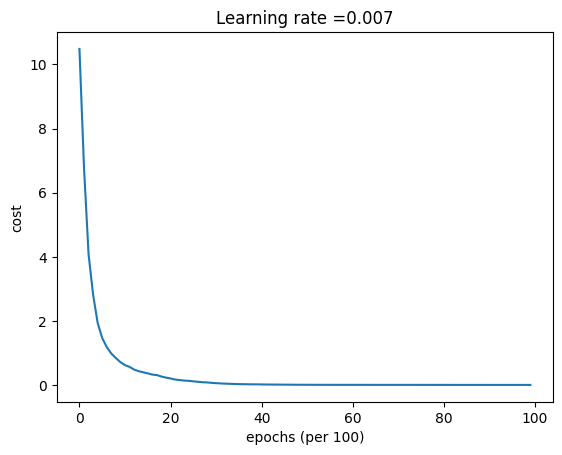

In [44]:
layer_dims = [X_train.shape[0], 255, 128, 64, 32, 16,y_train.shape[0]]
parameters, t, seed = model(
                    X_train, y_train, X_test, y_test,
                    learning_rate=0.007, lambd=0.01,
                    num_epochs=100, mini_batch_size = 8192,
                    beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8,
                    activation = 'relu',
                    layers_dims = layer_dims
                    )

In [45]:
m = x_test.shape[1]
y_pred, caches = forward_propagation(x_test, parameters, 'relu')

y_pred = np.argmax(y_pred, 0)

In [46]:
y_pred

array([2, 0, 9, ..., 3, 9, 2])

In [47]:
def test_prediction(index, parameters):
    current_image = x_test[:, index, None]
    y_pred, caches = forward_propagation(current_image, parameters, 'relu')
    # label = np.argmax(y_test[:,index, None])
    y_pred = np.argmax(y_pred)
    print("Prediction: ", y_pred)
    # print("Label: ", label)

    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  7


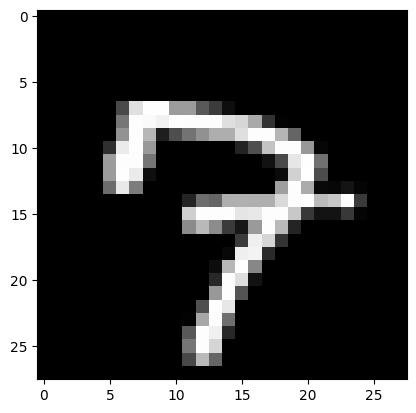

Prediction:  0


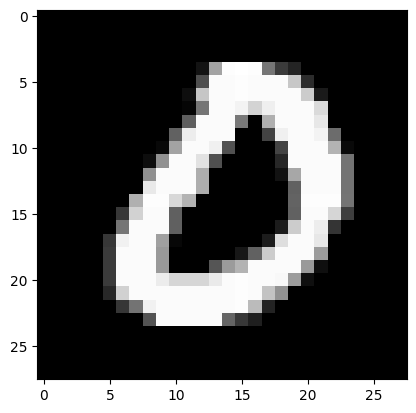

Prediction:  3


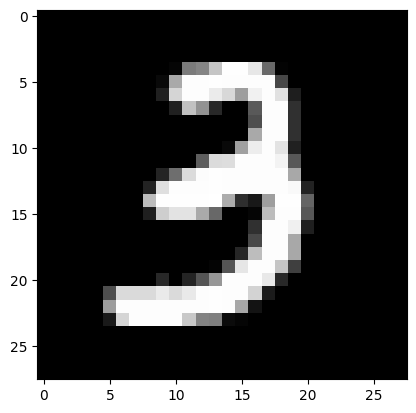

Prediction:  0


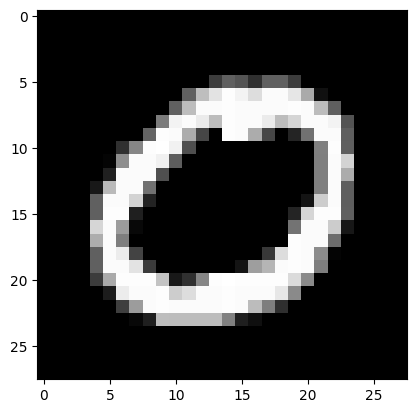

Prediction:  3


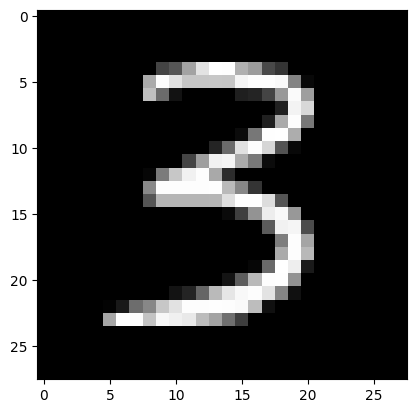

Prediction:  5


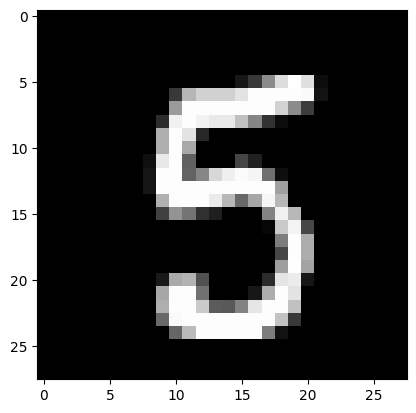

In [48]:
i = 1
test_prediction(i * 5, parameters)
test_prediction(i * 5+1, parameters)
test_prediction(i * 5+2, parameters)
test_prediction(i * 5+3, parameters)
test_prediction(i * 5+4, parameters)
test_prediction(i * 5+5, parameters)

In [52]:
sample = pd.read_csv('/content/sample_submission.csv')
w = sample['ImageId']

In [53]:
sample['Label'] = y_pred

In [54]:
sample.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [55]:
sample.to_csv('/content/submission.csv', index=False)

In [56]:
y_pred_dev, _ = forward_propagation(X_test, parameters, 'relu')
y_pred_dev = np.argmax(y_pred_dev, 0)
y_true = np.argmax(y_test,0)

In [57]:
index = np.argwhere([y_pred_dev != y_true])[:,1]

In [58]:
X_test[:,4].shape

(784,)

Prediction:  4
Label:  2


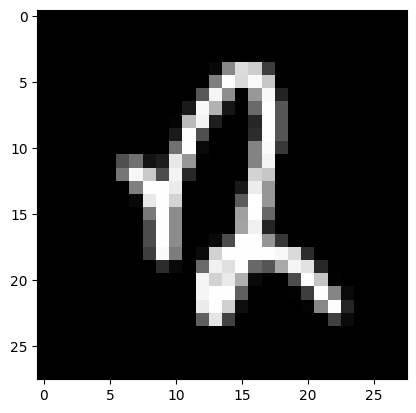

In [59]:
ins= 23

current_image = X_test[:, index[ins], None]
print("Prediction: ", y_pred_dev[index[ins]])
print("Label: ", y_true[index[ins]])

current_image = current_image.reshape((28, 28)) * 255
plt.gray()
plt.imshow(current_image, interpolation='nearest')
plt.show()

In [60]:
def along(X_ff, Y_ff, layers_dims, parameters, t, seed, learning_rate = 0.3, num_epochs = 30000, lambd = 0.01, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, activation = 'relu', print_cost = True):
    v,s = initialize_adam(parameters)
    # Loop (gradient descent)
    costs = []
    for i in range(num_epochs):

        cost_total = 0

        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X_ff, Y_ff, mini_batch_size, seed)

        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch


            # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
            AL, cache = forward_propagation(minibatch_X, parameters, activation)

            # compute the cost
            cost_total += compute_cost(AL, minibatch_Y, parameters=parameters, lambd=lambd)

            # Backward propagation.
            grads = backward_propagation(AL, minibatch_Y, parameters, cache, lambd, activation)

            # Update parameters.
            t = t + 1 # Adam counter
            parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
            # parameters = update_parameters(parameters, grads,learning_rate=learning_rate)


        # Print the cost every 1000 epoch
        if print_cost and i % 2 == 0:
            # learning_rate *= 1 / (1+0.96*i)
            print("\niter:{} \t cost: {} \t train_acc:{} \t dev_acc:{}".format(i, np.round(cost_total, 2), predict(X_ff, Y_ff, parameters, activation), predict(x.T, y.T, parameters, activation)))
        if print_cost and i % 1 == 0:
            costs.append(cost_total)
        if i % 1 == 0:
            print('=', end='')
    return parameters

In [61]:
y_along = y_test[:,index]
X_along = X_test[:,index]

In [62]:
layer_dims = [X_along.shape[0], 255, 128, 64, 32, 16,y_along.shape[0]]
par = along(
                    X_along, y_along,
                    learning_rate=0.007, lambd=0.01,
                    num_epochs=20, mini_batch_size = 32,
                    beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8,
                    activation = 'relu',
                    layers_dims = layer_dims,
                    parameters = parameters,
                    t = t,
                    seed = seed
                    )


iter:0 	 cost: 72.34 	 train_acc:0.25 	 dev_acc:0.2
==
iter:2 	 cost: 11.8 	 train_acc:0.18 	 dev_acc:0.2
==
iter:4 	 cost: 11.22 	 train_acc:0.15 	 dev_acc:0.1
==
iter:6 	 cost: 11.43 	 train_acc:0.15 	 dev_acc:0.1
==
iter:8 	 cost: 11.45 	 train_acc:0.15 	 dev_acc:0.1
==
iter:10 	 cost: 11.42 	 train_acc:0.15 	 dev_acc:0.1
==
iter:12 	 cost: 11.25 	 train_acc:0.15 	 dev_acc:0.1
==
iter:14 	 cost: 11.22 	 train_acc:0.15 	 dev_acc:0.1
==
iter:16 	 cost: 11.08 	 train_acc:0.15 	 dev_acc:0.1
==
iter:18 	 cost: 11.02 	 train_acc:0.15 	 dev_acc:0.1
==

In [63]:
y_pred_dev, _ = forward_propagation(x.T, par, 'relu')
y_pred_dev = np.argmax(y_pred_dev, 0)
y_true = np.argmax(y.T,0)

In [65]:
y_true[y_pred_dev == y_true].shape

(4351,)

In [66]:
from google.colab import files

# Download the file
files.download('/content/submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>